In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import scanpy as sc
import torch
import lineagevi

In [15]:
adata_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/adata_with_velocity.h5ad'
model_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/vae_velocity_model.pt'

adata = sc.read_h5ad(adata_path)

model = lineagevi.trainer.LineageVI(
    adata,
)

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

LineageVI(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=1805, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (mean_layer): Linear(in_features=128, out_features=647, bias=True)
    (logvar_layer): Linear(in_features=128, out_features=647, bias=True)
  )
  (gene_decoder): MaskedLinearDecoder(
    (linear): Linear(in_features=647, out_features=1805, bias=True)
  )
  (velocity_decoder): VelocityDecoder(
    (shared_decoder): Sequential(
      (0): Linear(in_features=647, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (gp_velocity_decoder): Linear(in_features=128, out_features=647, bias=True)
    (gene_velocity_decoder): Sequential(
      (0): Linear(in_features=128, out_features=5415, bias=True)
      (1): Softplus(beta=1.0, threshold=20.0)
    )
  )
)

In [22]:
outs = model.get_model_outputs(
        adata,
        n_samples=2,
        return_mean=False,
        return_negative_velo=True,
        base_seed=123,
        save_to_adata=False
    )

for k,v in outs.items():
    print(f'{k}:  {v.shape}')

recon:  (2, 3696, 1805)
z:  (2, 3696, 647)
mean:  (2, 3696, 647)
logvar:  (2, 3696, 647)
velocity_u:  (2, 3696, 1805)
velocity:  (2, 3696, 1805)
velocity_gp:  (2, 3696, 647)
alpha:  (2, 3696, 1805)
beta:  (2, 3696, 1805)
gamma:  (2, 3696, 1805)


In [25]:
outs = model.get_model_outputs(
        adata,
        n_samples=2,
        return_mean=False,
        return_negative_velo=True,
        base_seed=123,
        save_to_adata=True
    )

adata

AnnData object with n_obs × n_vars = 3696 × 1805
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'indices', 'log1p', 'neighbors', 'pca', 'terms'
    obsm: 'X_pca', 'X_umap', 'velocity_gp', 'z', 'mean', 'logvar'
    varm: 'I', 'PCs'
    layers: 'Ms', 'Mu', 'recon', 'spliced', 'unspliced', 'velocity', 'velocity_u', 'alpha', 'beta', 'gamma'
    obsp: 'connectivities', 'distances'

In [29]:
adata.var_names

Index(['Sntg1', 'Snhg6', 'Ncoa2', 'Sbspon', 'Ube2w', 'Mcm3', 'Fam135a',
       'Adgrb3', 'Tmem131', 'Tbc1d8',
       ...
       'Hsd17b10', 'Rragb', 'Map7d2', 'Sh3kbp1', 'Map3k15', 'Rai2', 'Rbbp7',
       'Ap1s2', 'Uty', 'Ddx3y'],
      dtype='object', name='index', length=1805)

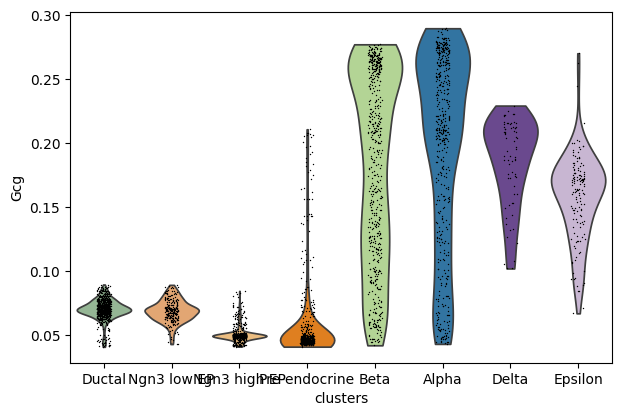

In [38]:
sc.pl.violin(adata, keys='Gcg', layer='alpha', groupby='clusters')

In [12]:
import numpy as np
# Same seed -> identical draw
_, v1 = model.get_velocity(adata, n_samples=1, return_mean=False, base_seed=123)
_, v2 = model.get_velocity(adata, n_samples=1, return_mean=False, base_seed=123)
assert np.allclose(v1, v2)

# Different seeds -> different draw
_, v3 = model.get_velocity(adata, n_samples=1, return_mean=False, base_seed=124)
assert not np.allclose(v1, v3)


AttributeError: 'LineageVI' object has no attribute 'get_velocity'

In [5]:
_, V = model.get_velocity(adata, n_samples=50, return_mean=False, base_seed=123)

In [6]:
V.shape

(50, 3696, 1805)

In [7]:
V[0,0] - V[0,1]


array([-0.04718103, -0.46680963,  0.10111748, ...,  0.13123634,
        0.03651446,  0.21248677], shape=(1805,), dtype=float32)

In [8]:
velocity_u, velocity = model.get_velocity(adata, n_samples=1, return_mean=False)
velocity.shape

(3696, 1805)

In [9]:
gp_velo = model.get_gp_velocity(adata, n_samples=1, return_mean=False)
gp_velo.shape

(3696, 647)

In [44]:
uncertainty_df, _ = model.get_directional_uncertainty(adata, use_gp_velo=False, n_samples=10)
uncertainty_df.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    6.5s


KeyboardInterrupt: 

In [60]:
gp_adata = model.build_gp_adata(adata, n_samples = 10, return_negative_velo=True)
gp_adata

AnnData object with n_obs × n_vars = 3696 × 647
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'directional_variance', 'directional_difference', 'directional_cosine_sim_variance', 'directional_cosine_sim_difference', 'directional_cosine_sim_mean', 'velocities_lineagevi_0_self_transition', 'velocities_lineagevi_1_self_transition', 'velocities_lineagevi_2_self_transition', 'velocities_lineagevi_3_self_transition', 'velocities_lineagevi_4_self_transition', 'velocities_lineagevi_5_self_transition', 'velocities_lineagevi_6_self_transition', 'velocities_lineagevi_7_self_transition', 'velocities_lineagevi_8_self_transition', 'velocities_lineagevi_9_self_transition', 'velocities_lineagevi_10_self_transition', 'velocities_lineagevi_11_self_transition', 'velocities_lineagevi_12_self_transition', 'velocities_lineagevi_13_self_transition', 'velocities_lineagevi_14_self_transition', 'velocities_lineagevi_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 2028 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 2572 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:  1.9min finished


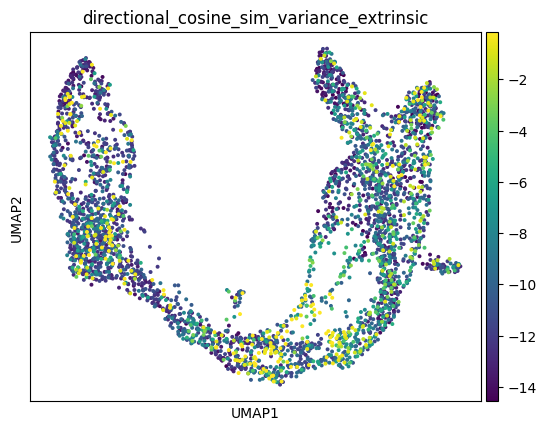

In [57]:
df = model.compute_extrinsic_uncertainty(
    adata,
    use_gp_velo=True,
    n_samples=25, 
    n_jobs=-1,
    show_plot=True)